In [31]:
import pandas as pd
from datetime import datetime
from pathlib import Path
import plotly.express as px 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [14]:
current_datetime =  datetime.now()
current_date_str = str(current_datetime.date()).replace('-','_')

current_directory = Path.cwd()
model_outputs_directory = current_directory / 'data/model_outputs' 

forwards_filename = current_date_str + '_forward_predictions.csv'
forwards_filepath = model_outputs_directory / forwards_filename

defense_filename = current_date_str + '_defense_predictions.csv'
defense_filepath = model_outputs_directory / defense_filename


player_data_directory = current_directory / 'data/processed/player_data'
player_data_filename = current_date_str + '_clean_player_data.csv'
player_data_filepath = player_data_directory / player_data_filename



forwards_model_df = pd.read_csv(forwards_filepath)
forwards_model_df = forwards_model_df.drop(columns=['Unnamed: 0'])
forwards_model_df['Position'] = 'F'

defense_model_df = pd.read_csv(defense_filepath)
defense_model_df = defense_model_df.drop(columns=['Unnamed: 0'])
defense_model_df['Position'] = 'D'


model_output_df = pd.concat([forwards_model_df, defense_model_df])

player_data_df = pd.read_csv(player_data_filepath)
player_data_df = player_data_df.drop(columns=['Unnamed: 0'])


We now want to drop unneeded columns from our player data, then merge with our model output dataframes 

In [15]:
print(player_data_df.columns)
player_data_df = player_data_df[player_data_df['Pos'] != 'G']

drop_columns = ['Team', 'specific_pos', 'Cap%', 'Salary','S/C', 'Ht', 'Wt', 'TOI', 'FO%']
player_data_df = player_data_df.drop(columns=drop_columns)

player_data_df = player_data_df.dropna()

Index(['Player', 'Age', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'EV', 'PP',
       'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S', 'S%', 'TOI', 'ATOI', 'OPS',
       'DPS', 'PS', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%', 'Ht', 'Wt', 'S/C',
       'Exp', 'Team', 'specific_pos', 'Cap%', 'Salary'],
      dtype='object')


In [16]:
def prep_atoi(atoi_string):
    list = atoi_string.split(':')
    minutes = int(list[0])
    seconds = int(list[1])

    return minutes + (seconds/60)



player_data_df['ATOI'] = player_data_df['ATOI'].apply(prep_atoi)


In [17]:
df = player_data_df.merge(model_output_df, on='Player', how='inner')

In [20]:
forward_corr_df = df.drop(columns=['Player', 'Team', 'Pos', 'Actual_Salary', 'Predicted_Salary'])
correlation_matrix = forward_corr_df.corr()['difference'].sort_values(ascending=False)
print(correlation_matrix)

ValueError: could not convert string to float: 'F'

Players are "overpaid" when difference is positive

In [22]:
fig = px.scatter(df, x='difference', y='Exp')
fig.show()

In [28]:
exp_range = np.arange(0,20,1)

/home/toomeh/miniconda3/envs/nhl_11_env/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:419: RuntimeWarning:

Mean of empty slice.

/home/toomeh/miniconda3/envs/nhl_11_env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide

/home/toomeh/miniconda3/envs/nhl_11_env/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:424: RuntimeWarning:

Mean of empty slice.



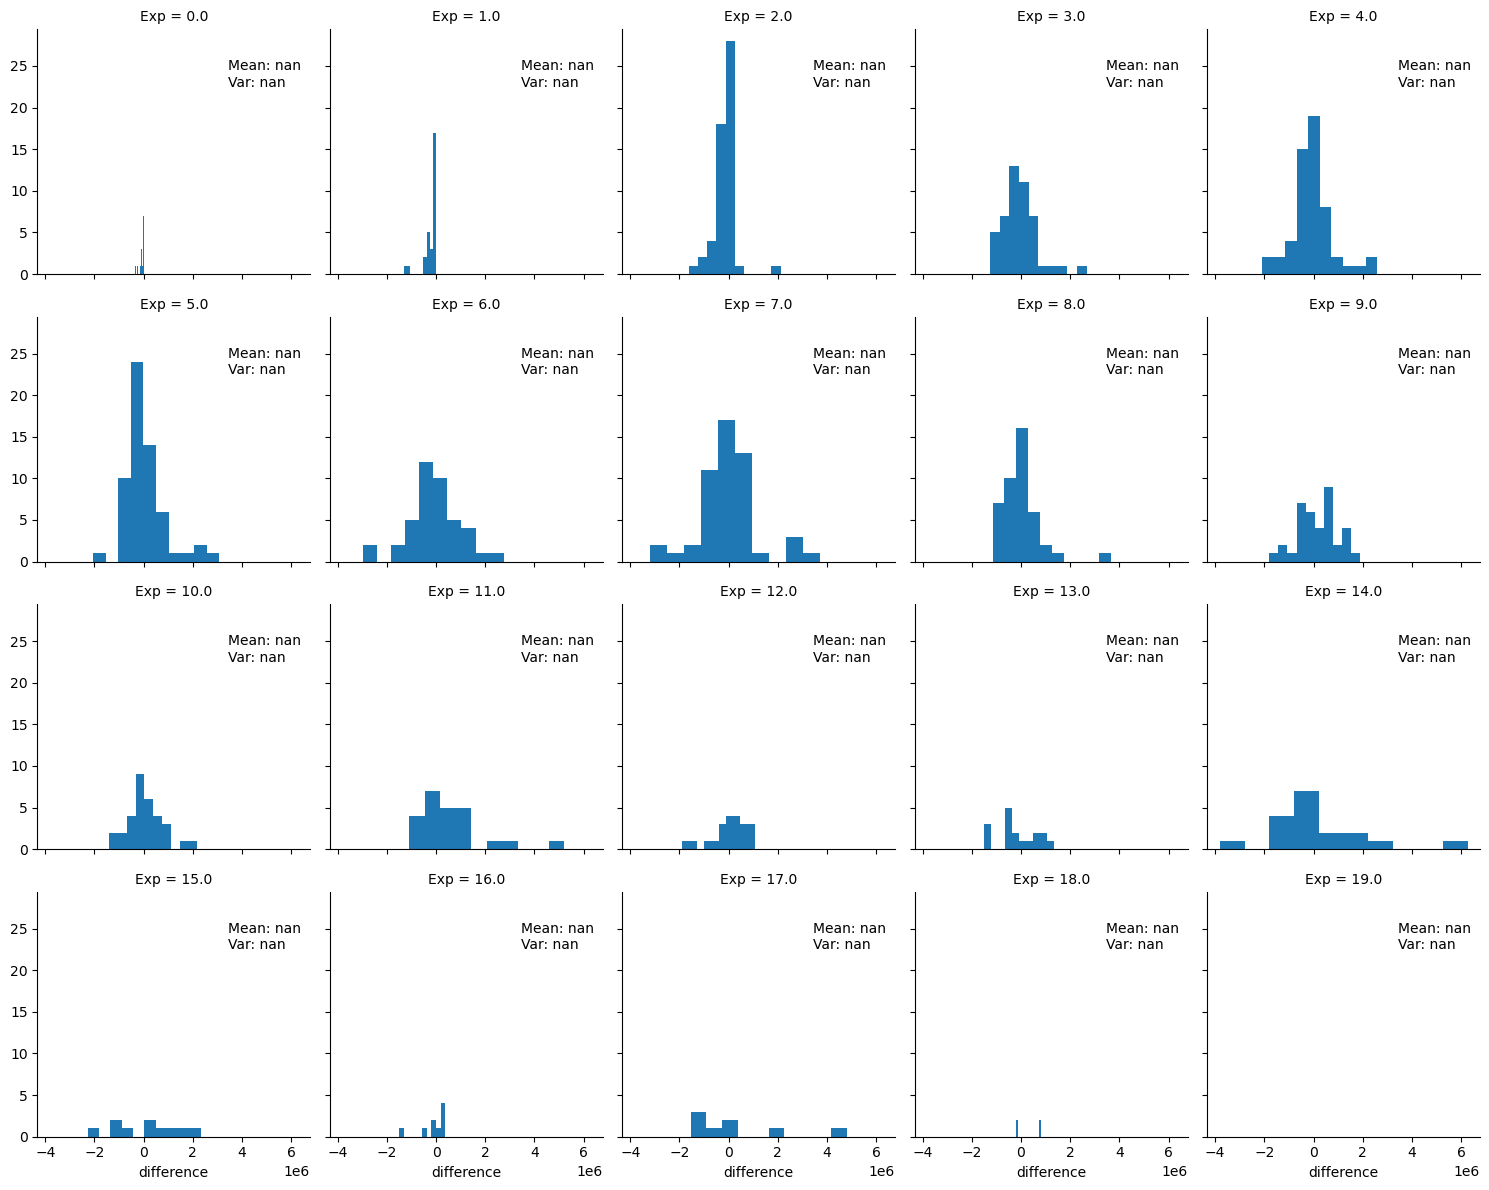

In [35]:
g = sns.FacetGrid(df, col="Exp", col_wrap=5, height=3)
g.map(plt.hist, "difference", bins=10)

for ax in g.axes.flat:
    exp_value = ax.get_title().split('=')[1].strip()
    data = df[df['Exp'] == exp_value]['difference'].dropna()
    mean, var= stats.norm.fit(data)
    ax.annotate(f"Mean: {mean:.2f}\nVar: {var:.2f}\n", 
                xy=(0.7, 0.7), xycoords='axes fraction', fontsize=10, ha='left')

plt.show()

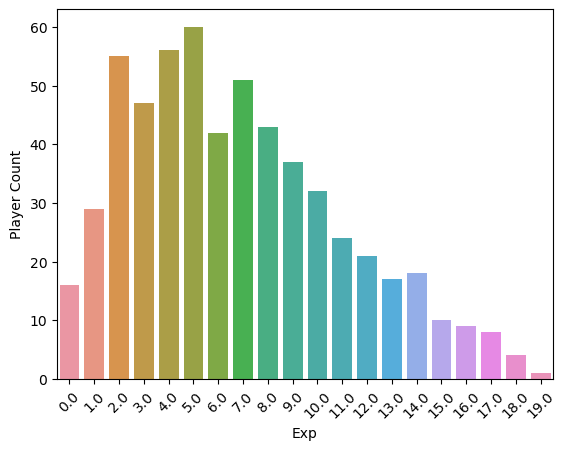

In [46]:
exp_counts = df['Exp'].value_counts()
exp_counts_df = exp_counts.reset_index()
exp_counts_df.columns = ['Exp', 'Player Count']

sns.barplot(data=exp_counts_df, x='Exp', y='Player Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [52]:
rookies = df[df['Exp'] < 3.0]
young = df[(df['Exp'] >= 3.0) & (df['Exp'] < 7.0)]
middle = df[(df['Exp'] >= 7.0) & (df['Exp'] < 11.0)]
veteran = df[df['Exp'] >= 11.0]

In [84]:
np.std(rookies['difference'])

379700.1825543059

In [97]:
def plot_histogram_with_fit(data:pd.DataFrame, feature:str, ax):

    sns.histplot(data, x=feature, ax=ax)
    


    mean = np.mean(data[feature])
    std = np.std(data[feature])
    ax.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.axvline(mean + std, color='g', linestyle='--', label=f'Std Dev: {std:.2f}')
    ax.axvline(mean - std, color='g', linestyle='--')
    ax.legend()



/home/toomeh/miniconda3/envs/nhl_11_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/toomeh/miniconda3/envs/nhl_11_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/toomeh/miniconda3/envs/nhl_11_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/toomeh/miniconda3/envs/nhl_11_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



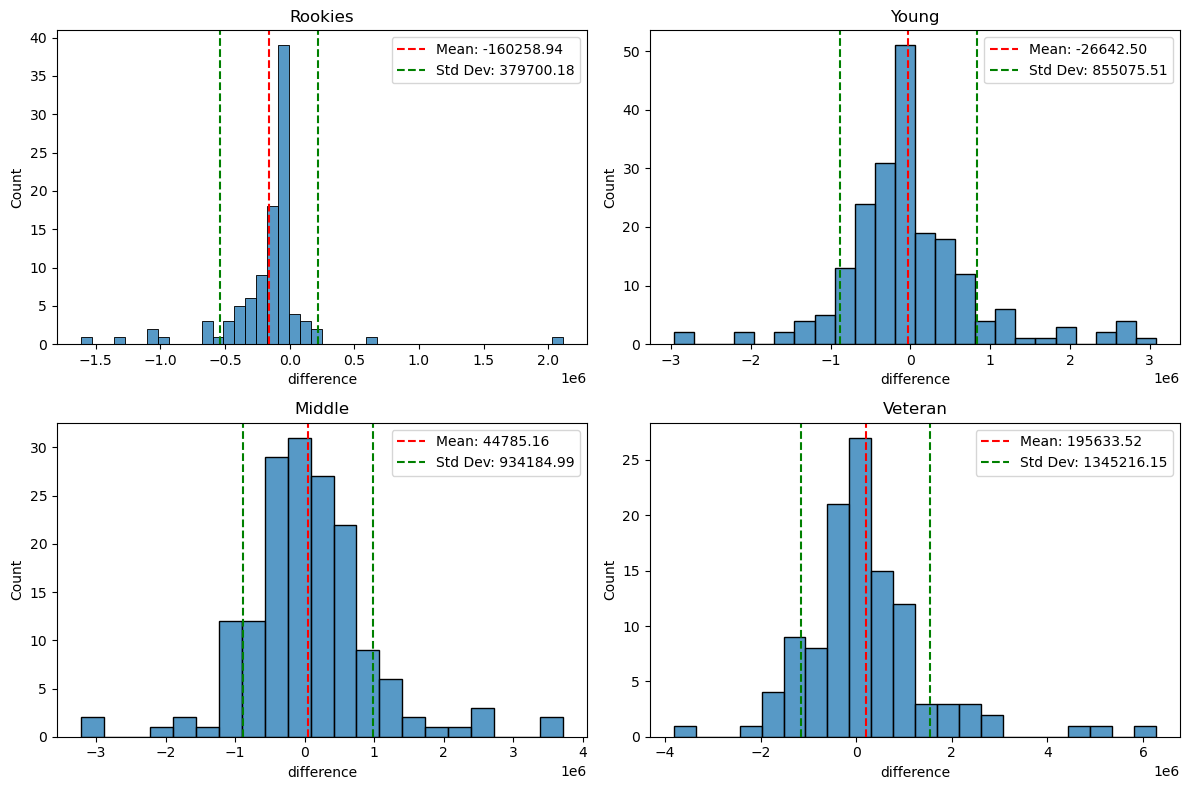

In [98]:
feature = 'difference'

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot histograms and fit for each segment
plot_histogram_with_fit(rookies, feature, axes[0, 0])
axes[0, 0].set_title('Rookies')

plot_histogram_with_fit(young, feature, axes[0, 1])
axes[0, 1].set_title('Young')

plot_histogram_with_fit(middle, feature, axes[1, 0])
axes[1, 0].set_title('Middle')

plot_histogram_with_fit(veteran, feature, axes[1, 1])
axes[1, 1].set_title('Veteran')

plt.tight_layout()
plt.show()

In [95]:
from scipy.stats import kurtosis
from scipy.stats import skew


df_list = [rookies, young, middle, veteran]


for df in df_list: 
    print(f'Mean: {np.mean(df["difference"])}')
    print(f'Standard Deviation: {np.std(df["difference"])}')


Mean: -160258.9375
Standard Deviation: 379700.1825543059
Mean: -26642.500146341477
Standard Deviation: 855075.5127040587
Mean: 44785.15742331287
Standard Deviation: 934184.9869899015
Mean: 195633.51714285716
Standard Deviation: 1345216.1468689581


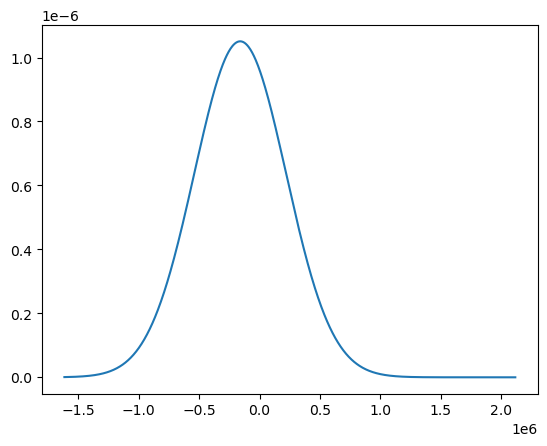

In [99]:
x_values = np.linspace(min(rookies['difference']), max(rookies['difference']), 1000)


y_values = stats.norm.pdf(x_values, np.mean(rookies['difference']), np.std(rookies['difference']))

plt.plot(x_values, y_values)

In [102]:
df[df['difference'] == np.max(df['difference'])]

,Player,Age,Pos,GP,G,A,PTS,+/-,PIM,EV,...,HIT,FOW,FOL,Exp,Actual_Salary,Predicted_Salary,difference,Team,Position,Segment
342,Jamie Benn,34.0,LW,49.0,8.0,21.0,29.0,1.0,31.0,6.0,...,46.0,281.0,161.0,14.0,9500000.0,3230189.0,6269810.7,DAL,F,Segment 4
